<h1>Example validation script</h1>
<p>In this notebook we walk you through the steps of validating your point predictions and pdfs. We will use the same codes that will be used in the final validation stage. </p>
<p>First, ensure that your repo is up to date, by running this command</p>
<code>cd /path/to/photoz-wg/</code>

Followed by 

<code>git pull</code>

<h3>The validation script</h3>
<p>The validation script is found in the validation directory. You may ignore this notebook, and call the validation script directly from the directory (or anywhere if you add the directory to your path variable). This will instantly check that your file is well formed, and then perform all the standard tests, and output the scores.</p>

usage like


<code>%>photoz_metrics.py data/PointPredictions1.fits</code>


or to do many pdfs predictions at a time

<code>%>photoz_metrics.py data/pdfPredictions*.hdf5</code>


or a mix of the two, many point prediction files, and many pdf files

<code>%>photoz_metrics.py data/pdfPredictions\*.hdf5 data/PointPredictions\*.fits</code>



or you can make more fine tuned validations using a configuration YaML file


<code>%>photoz_metrics.py config.yaml </code>



<h4>help file</h4>
If your just call it like this:

<code>%>photoz_metrics.py</code> 



We will write a example YaML file to the working directory.

<h3>The validation code</h3>
<p>Dependecies, pandas, astropy, pyYaml</p>

In [1]:
#some dependencies. We'll need YAML (pip install pyYaml)
import numpy as np
import sys
import os
import yaml

#what is the path to DES photo-z wg bucket/validation?
#for Ben this is:
#modify this for your system
path_bh = '/Users/hoyleb/Documents/python/modules/photoz-wg/validation/'

sys.path.append(path_bh)

import bh_photo_z_validation as pval

<h3>Load the point predictions files</h3>
<p>We assume that you already have the data in the correct format. This means it has the required point prediction redshift estimates, and Z_SPEC, and COADD_OBJECTS_ID and MAG_DETMODEL_I. We will now perform some "unit-tests" to ensure this.</p>

<p>In fact, in the code, we identify all the columnns that will be used in the specified tests, and check for their existence too!</p>

In [2]:
#change this to your fits file path
pointPredictionFitsPath = path_bh + 'tests/data/validPointPrediction.fits'

require_cols = ['Z_SPEC', 'COADD_OBJECTS_ID', 'MAG_DETMODEL_I', 'Z_MC']

okay, dataFrame = pval.valid_file(pointPredictionFitsPath, require_cols)
if okay is False:
    print "the file is not in the correct format"
    print "erorr message: " + dataFrame
print dataFrame[0:2]

COADD_OBJECTS_ID MAG_DETMODEL_I    WEIGHTS     ...     Z_SPEC          Z_MC    
---------------- -------------- -------------- ... -------------- -------------
               0  28.4614999009 0.682429573368 ...  1.00980074869  1.1448526257
               1  21.2833863978 0.768361144098 ... 0.968598671913 1.61458159011


<h3>Define the tests</h3>
<p>We next will build a test. We write each test as a really lovely YaML file. YaML is desgined to be easy for humans to read. You'll understand how easy each test becomes, in a few seconds. </p>

<p>Each test determines which metrics (such as $\sigma_{68}$ or the K-S test) will be measured, and optionally if we want to measure the metric by binning the data along one of the columns, e.g. if we want to bin along MAG_DETMODEL_I. We can also decide to set an allowed "tolerance", this informs us if the tests passed with the required precision</p>

<p>You don't need to write any tests if you don't want to. The standard ones are included already when you run the script from the command line. Below I shown an exmaple of what a test looks like. You can include as many tests, from as many sources as you like. Each test it it's own yaml file.</p>

<p>The base tests can be found here </p>

<code>%>ls photoz-wg/validation/testConfig/*.yaml</code>

And looks like this: [The comments '#' are also included in the file, for easy reading!]

===== begin YaML file =======

#paths to file locations. will assume '.fits' as point predictions '.hdf5' as pdf predictions, add more files to list to compare multiple files


filePaths: ['tests/data/validPointPrediction.fits', 'tests/data/validHDF.hdf5']

#Which metrics and tolerance should we measure either a list of metrics, such as and or a precomputed collection of group metrics and tolerances set blank, or delete this line to not use these preconfigured metrics/bins/tolerances

standardPredictions: [/testConfig/photoz.yaml, /testConfig/weak_lensing.yaml]

#what will the path/ and or/base file name of the results be called?

resultsFilePrefix: myResultsOutput

#And or / additionally choose your own metrics, as list
#remove these if not required
#these are the point prediction tests

point:
    
    #which photo-z predictions do we want to test
    predictions: [MODE_Z, MEAN_Z, Z_MC]
    
    #what is the true redshift that we will compare with?
    truths: Z_SPEC
    
    #should we calculated weighted metrics where available?
    weights: WEIGHTS

    #what metrics do we want to measure. "numpy.std" is the standard deviation from numpy
    
    # and "bh_photo_z_validation.sigma_68" is the sigma_68 metric found in the bh_photo_z_validation.py file
    
    metrics: [numpy.std, numpy.median, bh_photo_z_validation.sigma_68, bh_photo_z_validation.outlier_fraction]
    
    #do we want to assign an accetable tolerance to each of these tests?
    tolerance: [0.4, 0.001, 0.02, 5]
    
    #Finally do we want to also measure the metrics in some "bins".
    #we define the column_name: 'string of bins / string of function that makes bins'
    bins: [MAG_DETMODEL_I: '[10, 15, 20, 25, 30]', MODE_Z: 'numpy.linspace(0, 2, 20)']

    #Should we calculate errors on each metric? if yes state how
    #you can include as many different error functions as you like.
    error_function: [bh_photo_z_validation.bootstrap_mean_error]

#these are the pdf tests

pdf: 
    #we can examine individual redshift pdfs against a truth value. Remove this part if you don't want this
    individual:
        truths: Z_SPEC
        
        #one statistic is calcualted in bh_photo_z_validation.py eval_pdf_point(), add your own at will.
        metrics: [bh_photo_z_validation.eval_pdf_point]
        bins: [MAG_DETMODEL_I: '[ 17.5, 19, 22, 25]']
        tolerance: [0.7, 20]
        #shall we use weights when calculating metrics, if so specify here.
        weights: WEIGHTS

    #or shall we compare against stacked pdfs
    stacks:
        truths: Z_SPEC
        #we convert truths to a distribution by choosing these bins
        truth_bins: [Z_SPEC: 'numpy.linspace(0, 2, 4)']

        #which additional bins shall we use to measure metrics in?
        metric_bins: [MAG_DETMODEL_I: '[ 17.5, 19, 22, 25]']
        
        #which pdf/ distribution comparison metrics should we measure 
        metrics: [bh_photo_z_validation.kstest, bh_photo_z_validation.npoisson, bh_photo_z_validation.log_loss]
        tolerance: [0.7, 20]
        #shall we use weights when calculating metrics, if so specify here.
        weights: WEIGHTS
===== end YaML file =======

You see that we have now defined a set of tests for both point predictions, and pdfs.


<h3>Loading the tests</h3>
<p>We load the tests like this!</p>

In [3]:
testYamlPath = path_bh + 'testConfig/photoz.yaml'
testConfig = yaml.load(open(testYamlPath, 'r'))

#the YaML file is parsed nicely to a python dictionary!
print testConfig
print "\nExample of extracting a statistic to measure\n"
print testConfig['point']['metrics'][1]
print "\nExample of which error we can assign to this metric\n"
print testConfig['point']['error_function'][0]

print "\nThis means look in bh_photo_z_validation.py to see this function. You can add your own error function too!"

{'pdf': {'individual': {'metrics': ['bh_photo_z_validation.eval_pdf_point'], 'truths': 'Z_SPEC', 'metric_bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}], 'tolerance': [0.7, 20], 'weights': 'WEIGHTS'}, 'stacks': {'metrics': ['bh_photo_z_validation.kstest', 'bh_photo_z_validation.npoisson', 'bh_photo_z_validation.log_loss'], 'metric_bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}], 'weights': 'WEIGHTS', 'truth_bins': [{'Z_SPEC': 'numpy.linspace(0, 2, 4)'}], 'tolerance': [0.7, 20], 'truths': 'Z_SPEC'}}, 'point': {'metrics': ['numpy.std', 'numpy.median', 'bh_photo_z_validation.sigma_68', 'bh_photo_z_validation.outlier_fraction'], 'weights': 'WEIGHTS', 'error_function': ['bh_photo_z_validation.bootstrap_mean_error'], 'tolerance': [0.4, 0.001, 0.02, 5], 'truths': 'Z_SPEC', 'predictions': ['MODE_Z', 'MEAN_Z', 'Z_MC'], 'bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}, {'MODE_Z': 'numpy.linspace(0, 2, 4)'}]}}

Example of extracting a statistic to measure

numpy.median

Example of which e

<h3>YaML corrupt?</h3>
<p>If your YaML file doesn't work, copy and check it here: http://yaml-online-parser.appspot.com

<h3>Running a test for point predictions</h3>
<p>Now we can play some testing magic. One thing to note, is they Python is <b>friggin</b> awesome. Remember we wrote the metric like this: 'bh_photo_z_validation.sigma_68', well we can turn this into an executable using a function found in bh_photo_z_validation.py called get_function(). We'll see this in the below.</p>

In [4]:
pointTestConfig = testConfig['point']
for eachPointPrediction in pointTestConfig['predictions']:
    #let's calcalate the redshift scaled residuals Deltaz = (z - photz) / (1 + z)
    deltaz_1pz = pval.delta_z_1pz(dataFrame[pointTestConfig['truths']], dataFrame[eachPointPrediction])
    
    #are we adding weights to each galaxy prediction?
    weights = dataFrame[pointTestConfig['weights']]
    
    #now let's calculate the value of each chosen metric
    for i, eachMetric in enumerate(pointTestConfig['metrics']):
        
        #amazing metric string to function conversion. 
        #Add your own functions by putting them in bh_photo_z_validation.py
        metric_function = pval.get_function(eachMetric)
        metric_value =  metric_function(deltaz_1pz)
        
        #no add our generic error function, we'll need weights for this
        error_function = pval.get_function(pointTestConfig['error_function'][0])
        
        error_value = error_function(deltaz_1pz, weights, metric_function)
        
        print " \n"
        print "using file: " + pointPredictionFitsPath 
        print "point prediction: " + eachPointPrediction 
        print "we measure the statistic: " + eachMetric.split('.')[-1] 
        print "and get the value: " + str(metric_value) + " [or error and mean from bootstrap]", error_value
        if metric_value < pointTestConfig['tolerance'][i]:
            print "This bettter than expected!"
        else:
            print "This is worse than expected!"

# All the results of these tests will be printed to the screen below

 

using file: /Users/hoyleb/Documents/python/modules/photoz-wg/validation/tests/data/validPointPrediction.fits
point prediction: MODE_Z
we measure the statistic: std
and get the value: 0.254437821905 [or error and mean from bootstrap] {'sigma': 0.0045411716404448535, 'mean': 0.25293282672424039}
This bettter than expected!
 

using file: /Users/hoyleb/Documents/python/modules/photoz-wg/validation/tests/data/validPointPrediction.fits
point prediction: MODE_Z
we measure the statistic: median
and get the value: 0.187183839678 [or error and mean from bootstrap] {'sigma': 0.0089605536732132625, 'mean': 0.18379662698786731}
This is worse than expected!
 

using file: /Users/hoyleb/Documents/python/modules/photoz-wg/validation/tests/data/validPointPrediction.fits
point prediction: MODE_Z
we measure the statistic: sigma_68
and get the value: 0.278159006702 [or error and mean from bootstrap] {'sigma': 0.0074230176208607427, 'mean': 0.27710315471384972}
This is worse than expected!
 

using fil

<h2>pdf tests</h2>
<p>Now let's turn our attention to the pdf tests. Let's load them and look at them.</p>

In [5]:
pdfTestConfig = testConfig['pdf']
print pdfTestConfig

{'individual': {'metrics': ['bh_photo_z_validation.eval_pdf_point'], 'truths': 'Z_SPEC', 'metric_bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}], 'tolerance': [0.7, 20], 'weights': 'WEIGHTS'}, 'stacks': {'metrics': ['bh_photo_z_validation.kstest', 'bh_photo_z_validation.npoisson', 'bh_photo_z_validation.log_loss'], 'metric_bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}], 'weights': 'WEIGHTS', 'truth_bins': [{'Z_SPEC': 'numpy.linspace(0, 2, 4)'}], 'tolerance': [0.7, 20], 'truths': 'Z_SPEC'}}


<h3>Load pdf data</h3>
<p>Lets load some data, and check that the data file is valid, and contains the columns we will be using.</p>

In [6]:
pdfPredictionFitsPath = path_bh + 'tests/data/validHDF.hdf5'

require_cols = ['Z_SPEC', 'COADD_OBJECTS_ID', 'MAG_DETMODEL_I']

okay, dataFrame = pval.valid_file(pdfPredictionFitsPath, require_cols)
if okay is False:
    print "the file is not in the correct format"
    print "erorr message: " + dataFrame
print dataFrame[0:1]

   COADD_OBJECTS_ID  pdf_0.0  pdf_0.00666666666667  pdf_0.0133333333333  \
0                 0        0                     0                    0   

   pdf_0.02  pdf_0.0266666666667  pdf_0.0333333333333  pdf_0.04  \
0         0                    0                    0         0   

   pdf_0.0466666666667  pdf_0.0533333333333       ...        \
0                    0                    0       ...         

   pdf_1.95333333333  pdf_1.96  pdf_1.96666666667  pdf_1.97333333333  \
0                  0         0                  0                  0   

   pdf_1.98  pdf_1.98666666667  pdf_1.99333333333   Z_SPEC    WEIGHT  \
0         0                  0                  0  1.11411  0.000687   

   MAG_DETMODEL_I  
0       17.914148  

[1 rows x 304 columns]


<h3>pdf array</h3>
Let's extract the pdfs as an N-darray of shape (ngals, nbins).

We also have access to the bin edges using the pdf_key valus<p>

In [7]:
zcols = [c for c in dataFrame.keys() if 'pdf_' in c]
print "pdf bin cols", zcols[0:3]
zbins = np.array([float(c.split('f_')[-1]) for c in zcols])
print "pdf bin centers", zbins[0:3]

pdf bin cols ['pdf_0.0', 'pdf_0.00666666666667', 'pdf_0.0133333333333']
pdf bin centers [ 0.          0.00666667  0.01333333]


In [8]:
pdfs = np.array(dataFrame[zcols])

<h3>Applying some tests</h3>
Let's apply some test. First let's stack all pdfs and plot them against the Z_SPEC dist. (note, this is all random data, so don't expect a correlation!). We'll use tools found in bh_photo_z_validation.py to do all the heavy lifting

In [9]:
#stack all pdfs across all gals
stackedPdf = pval.stackpdfs(pdfs)

#normalise this stack
normStackedPdf = pval.normalisepdfs(stackedPdf, zbins)

#make df for Z_SPEC #numpy.histogram needs the final bin edge
dndz = np.histogram(dataFrame['Z_SPEC'], bins=np.append(zbins,2))[0]*1.0
z_pdf = pval.normalisepdfs(dndz, zbins)


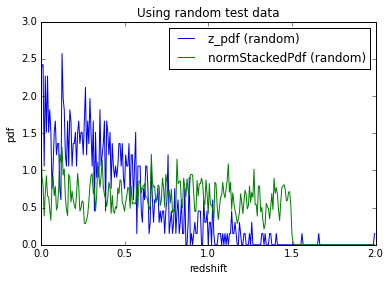

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(zbins, z_pdf, label='z_pdf (random)')
plt.plot(zbins, normStackedPdf, label='normStackedPdf (random)')
plt.title('Using random test data')
plt.xlabel('redshift')
plt.ylabel('pdf')
plt.legend()

<h3>Rubbish results?</h3>
<p>Yes! As expected, we are just using some meaningless, random, made up data.</p>
<p>Let's continue with the tutorial and perform some other comparisons on these (meaningless) distributions!</p>
<p>Let's find how much of each galaxy's pdf sits within some bin.<p>

In [11]:
pdf_in_int = pval.integrate_dist_bin(pdfs,zbins, 0.1, 0.3)

<p>Now, let's plot a few of those with lots of pdf in the bin</p>

(0, 0.5)

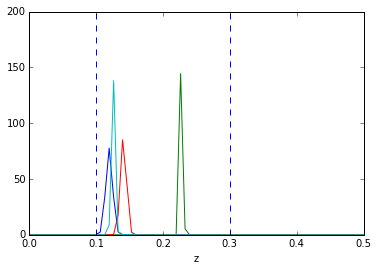

In [12]:
i = pdf_in_int > 0.95
for j in range(4):
    plt.plot(zbins, pdfs[i][j])
plt.plot([0.1,0.1], [0,200], '--b')
plt.plot([0.3,0.3], [0,200], '--b')
plt.xlabel('z')
plt.xlim(0,0.5)

and plot a few with only a little weight in the bin

(0.08, 0.35)

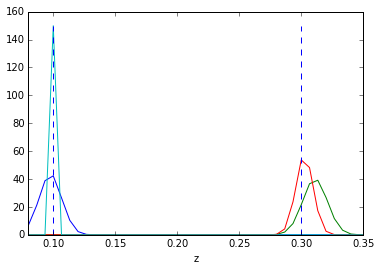

In [13]:
i = (pdf_in_int > 0.1) * (pdf_in_int < 0.5)
for j in range(4):
    plt.plot(zbins, pdfs[i][j])
plt.plot([0.1,0.1], [0,150], '--b')
plt.plot([0.3,0.3], [0,150], '--b')
plt.xlabel('z')
plt.xlim(0.08,0.35)